##Imports

In [0]:

%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader



##Initialization

In [0]:

# Initialize Batch Size
batch_size = 64

# Load Dataset
train_dataset = datasets.MNIST(root='data', train=True, download =True, transform=transforms.ToTensor())

# Prepare the dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)


##Data Visualization

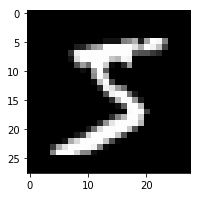

In [28]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
px = fig.add_subplot(111)
px.imshow(img, cmap='gray')